In [1]:
import sys
import cv2
import numpy as np
import tensorflow as tf
from glob import *
import os

Load graph

In [2]:
def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)

    return graph

In [3]:
def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

In [4]:
def read_tensor_from_image_file(file_name, input_height=299, input_width=299,
                input_mean=0, input_std=255):
  
    input_name = "file_reader"
    output_name = "normalized"
    file_reader = tf.read_file(file_name, input_name)
    if file_name.endswith(".png"):
        image_reader = tf.image.decode_png(file_reader, channels = 3,
                                           name='png_reader')
    elif file_name.endswith(".gif"):
        image_reader = tf.squeeze(tf.image.decode_gif(file_reader,
                                                      name='gif_reader'))
    elif file_name.endswith(".bmp"):
        image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
    else:
        image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                            name='jpeg_reader')
    float_caster = tf.cast(image_reader, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0);
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    sess = tf.Session()
    result = sess.run(normalized)

    return result

In [5]:
class DriverClassifier(object):
    def __init__(self):
        model_path = "output_graph.pb"
        label_path = "output_labels.txt"
        
        self.labels= load_labels(label_path)
        self.graph = load_graph(model_path)
        print('Model loaded')
        
    def classify_pic(self, image_file_list):
        t_arr=[]
        for image_file in image_file_list:
            t = read_tensor_from_image_file(image_file)
            t_arr.append(t[0])
        #t_arr = np.squeeze(t_arr)
        
        input_name = "import/Mul"
        output_name = "import/final_result"
        input_operation = self.graph.get_operation_by_name(input_name)
        output_operation = self.graph.get_operation_by_name(output_name)
        
        with tf.Session(graph=self.graph) as sess:
                    results_arr = sess.run(output_operation.outputs[0],
                              {input_operation.outputs[0]: t_arr})
        
        #results_arr = np.squeeze(results_arr)
        '''
        print('results: ', results)
        print('labels: ', self.labels)
        top_k = results.argsort()[-5:][::-1]
        
        first = top_k[0]
        print('position: ', first, '; img category: ', self.labels[first])
        '''
        
        print('results_arr.shape: ', results_arr.shape)
        results_dict_arr=[]
        for results in results_arr:
            results_dict = {}
            for i in range(len(self.labels)):
                results_dict[self.labels[i]]=results[i]
            results_dict_arr.append(results_dict)
        
        return results_dict_arr
            

In [6]:
driverClassifier = DriverClassifier()

Model loaded


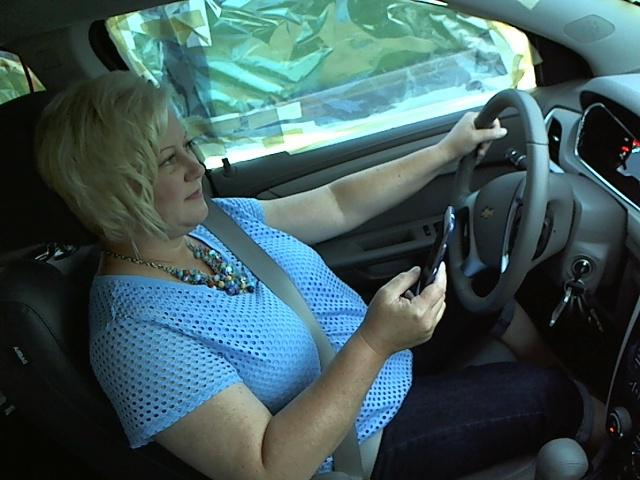

In [7]:
img_path = 'data/sample/valid/c1/img_7422.jpg'
from IPython.display import Image
Image(filename=img_path) 


In [8]:
print('classifying image')
img = cv2.imread(img_path)
img_arr=[]
img_arr.append(img_path)
res = driverClassifier.classify_pic(img_arr)
print('result: ', res)

classifying image
results_arr.shape:  (1, 10)
result:  [{'c2': 0.0017477645, 'c3': 0.06267149, 'c7': 0.076651379, 'c5': 0.0031497767, 'c6': 0.013713417, 'c4': 0.0080556804, 'c9': 0.070938453, 'c8': 0.11318363, 'c1': 0.5901041, 'c0': 0.059784323}]


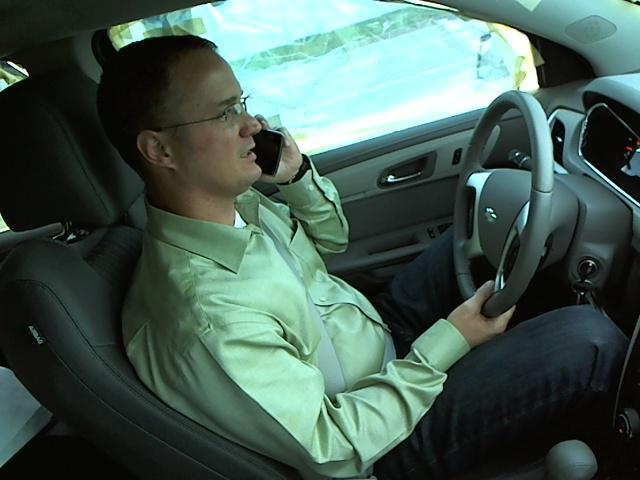

In [9]:
img_path = 'data/sample/valid/c4/img_15449.jpg'
from IPython.display import Image
Image(filename=img_path) 

In [11]:
img = cv2.imread(img_path)
img_arr=[]
img_arr.append(img_path)
img_arr.append('data/sample/valid/c6/img_13053.jpg')
res = driverClassifier.classify_pic(img_arr)
print('result: ', res)

ValueError: Cannot feed value of shape (2, 299, 299, 3) for Tensor 'import/Mul:0', which has shape '(1, 299, 299, 3)'

Iterate over all files and invoke the classify

In [11]:
#print('img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9')
count = 0
out_file = open("submisstion.csv.n", "w")
out_file.write('img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9\n')
#for f in glob('data/sample/valid/c?/*.jpg'):
for f in glob('data/test/*.jpg'):
    #print('classifying image: ', f)
    res = driverClassifier.classify_pic(f)
    #print(res)    
    last_slash = f.rfind('/')
    res_str = f[last_slash+1:]
    for i in range(len(res)):
        res_str += ','+ str(res['c'+str(i)])
    out_file.write(res_str + "\n")
    count+=1
    if count % 100 == 0:
        print('Processed ', count, ' images')
    #elif count > 5:
    #    break
    
out_file.close()
print("Done!")

Done!
